# Load original Magnetograms

- get pixels within 0.55Ic
- calculate mean blos
- calculate total unsigned LOS flux
- compare to the values from the remapped pickles

In [174]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import matplotlib as mpl
import sunpy.visualization.colormaps
import _pickle as cPickle
from datetime import datetime as dt
import sys
sys.path.append('../src/')
from pickle_loader import get_hrt_hmi_arr_from_pickles_45s
from apply_hmi_psf import *
from reproject_funcs import mu_angle_arr, center_coord

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d/%m %H:%M')

font = {'family' : 'Open Sans',
        'weight' : 'normal',
        'size'   : 15}

import matplotlib as mpl
mpl.rc_file_defaults()
plt.rc('font', **font)
mpl.rcParams['image.origin'] = 'lower'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [2]:
hrt_files = []
for i in [12,13,14,15,16,17]:
    tmp = os.listdir(f'/scratch/solo/phi/AR_Long_Term_2023_SL/l2/2023-10-{i}/')
    tmp_blos_files = [f'/scratch/solo/phi/AR_Long_Term_2023_SL/l2/2023-10-{i}/'+j for j in tmp if 'blos' in j]
    hrt_files = hrt_files + tmp_blos_files
hrt_files.sort()

In [3]:
hrt_icfiles = []
for i in [12,13,14,15,16,17]:
    tmp = os.listdir(f'/scratch/solo/phi/AR_Long_Term_2023_SL/l2/2023-10-{i}/')
    tmp_ic_files = [f'/scratch/solo/phi/AR_Long_Term_2023_SL/l2/2023-10-{i}/'+j for j in tmp if 'icnt' in j]
    hrt_icfiles = hrt_icfiles + tmp_ic_files
hrt_icfiles.sort()

In [235]:
idx = np.where(fits.getdata(hrt_icfiles[0])[100:,100:] <= 0.55)

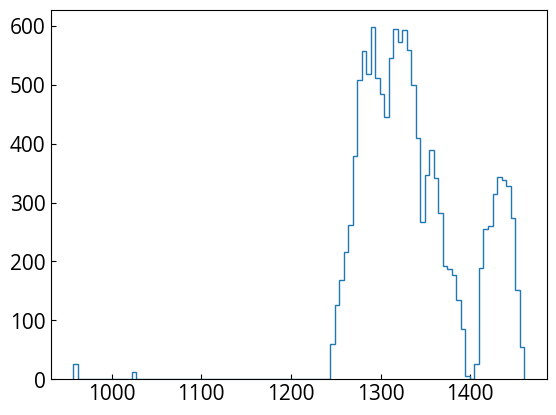

In [236]:
plt.hist(idx[1].flatten(), bins=100, label='Histogram of Umbra Pixels Location', histtype='step')
plt.show()

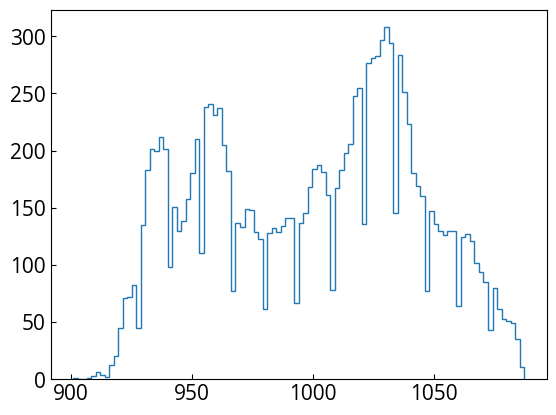

In [237]:
plt.figure()
plt.hist(idx[0].flatten(), bins=100, label='Histogram of Umbra Pixels Location', histtype='step')
plt.show()

In [249]:
# STEPS

# 1. Get the blos and icnt data
# 2. Apply HMI PSF
# 3. Correct HRT WCS
# 4. Correct HRT data for CLV
# 5. Get the umbra pixels
# 6. Get the blos pixels in the umbra
# 7. Get the mu values for the blos pixels

blos_pixels_list = []
hrt_mu_list = []

i = 0

for icnt, blos in zip(hrt_icfiles,hrt_files):
    icnt_data = fits.getdata(icnt)
    blos_data = fits.getdata(blos)

    h = fits.getheader(icnt)
    phi_dsun = h['DSUN_OBS']
    hmi_psf = make_psf_hmi_th(icnt_data.shape[0],phi_dsun)
    hmi_psf /= hmi_psf.max()

    new_icnt = fftshift(ifft2(fft2(icnt_data)/icnt_data.size * fft2(hmi_psf/hmi_psf.sum())).real * icnt_data.size) 
    new_blos = fftshift(ifft2(fft2(blos_data)/blos_data.size * fft2(hmi_psf/hmi_psf.sum())).real * blos_data.size) 

    #get the mu values for the blos pixels
    fileDID = h['PHIDATID']
    date = icnt.split('202310')[1].split('T')[0]

    wcs_crval_corr_file = f'/data/slam/sinjan/arlongterm_hrt_wcs_corr/hrt_CRVAL_corrections_202310{date}.json'

    with open(wcs_crval_corr_file) as f:
        err = json.load(f)

    err1 = err[fileDID]
    errx = err1[0]
    erry = err1[1]
    h['CRVAL1']=h['CRVAL1']-errx
    h['CRVAL2']=h['CRVAL2']-erry

    wcs_crpix_corr_file = f'/data/slam/sinjan/arlongterm_hrt_wcs_corr/hrt_CRPIX_corrections_202310{date}.json'

    with open(wcs_crpix_corr_file) as f:
        err = json.load(f)

    err1 = err[fileDID]
    errx = err1[0]
    erry = err1[1]
    h['CRPIX1']=h['CRPIX1']-errx
    h['CRPIX2']=h['CRPIX2']-erry

    mu = muSO_map(h,icnt_data.shape)
    clv = CLV(mu)

    new_icnt = new_icnt/clv

    norm_pix = np.where((mu >= 0.8) & (icnt_data >= 0.8))

    new_norm = new_icnt[norm_pix].mean()

    new_icnt /= new_norm

    umbra_pixels = np.where(new_icnt[100:,100:] <= 0.55)

    blos_pixels = new_blos[100:,100:][umbra_pixels]

    blos_pixels_list.append(blos_pixels)

    #get the mu values for the blos pixels
    fileDID = h['PHIDATID']
    date = icnt.split('202310')[1].split('T')[0]

    wcs_corr_file = f'/data/slam/sinjan/arlongterm_hrt_wcs_corr/hrt_CRVAL_corrections_202310{date}.json'

    with open(wcs_corr_file) as f:
        err = json.load(f)

    err1 = err[fileDID]
    errx = err1[0]
    erry = err1[1]
    h['CRVAL1']=h['CRVAL1']-errx
    h['CRVAL2']=h['CRVAL2']-erry
    hrt_mu=mu_angle_arr(h).reshape(blos_data.shape)

    hrt_mu_list.append(hrt_mu[100:,100:][umbra_pixels])

    # if i >= 126:

    #     copy = new_blos.copy()
    #     copy[100:,100:][umbra_pixels] = np.nan

    #     cmap = mpl.colormaps['hmimag']
    #     cmap.set_bad('black', alpha=1)
    #     plt.figure()
    #     plt.imshow(copy, cmap=cmap, origin="lower", vmin=-2000, vmax=2000)
    #     filename = blos.split("/")[-1]
    #     plt.title(f'{filename}')
    #     plt.show()

    #     hrt_mu_copy = hrt_mu.copy()
    #     hrt_mu_copy[100:,100:][umbra_pixels] = np.nan
    #     cmap = mpl.colormaps['viridis']
    #     cmap.set_bad('black', alpha=1)

    #     plt.figure()
    #     im=plt.imshow(hrt_mu, cmap=cmap,origin="lower", vmin=0, vmax=1)
    #     plt.colorbar(im)
    #     CS = plt.contour(hrt_mu, levels=[0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.99], colors='black', linewidths=0.5)
    #     plt.clabel(CS)
    #     plt.show()

    #     plt.figure()
    #     plt.imshow(new_icnt,cmap='gist_heat',vmin=0,vmax=1.4,origin='lower')
    #     plt.colorbar()
    #     plt.show()

    i += 1

0.1559012033565535
153
0.15606354292662533
153
0.15622702754838275
153
0.15639166470734966
154
0.15655742737468822
154
0.1567243125013042
154
0.15689232405295292
154
0.15706144670207797
154
0.15723167649814448
154
0.15740301312891913
155
0.15757544091063289
155
0.15774895711600057
155
0.1579235564790402
155
0.1580992340997979
155
0.15827597570466423
155
0.15845379496480794
156
0.15863263003472683
156
0.1588125575029381
156
0.15899350516857558
156
0.15917551854626763
156
0.15935854945434993
156
0.15954260408249446
157
0.1597276720501741
157
0.15991374921602944
157
0.16010082779284138
157
0.16028891353578703
157
0.16047799966467602
158
0.16066806467616787
158
0.16085910021810124
158
0.16105110763939168
158
0.16124409355930358
158
0.16143802160315873
159
0.16163293040736273
159
0.16182876640951077
159
0.1620255689985145
159
0.162223286235793
159
0.1624219123399485
160
0.16262148823056843
160
0.1628219636117371
160
0.16302335596278075
160
0.16322564873872866
160
0.16342883421577503
160
0.1

In [163]:
mean_blos = [np.mean(blos_pixels) for blos_pixels in blos_pixels_list]
pixel_size_ms = np.array([(fits.getheader(blos)['DSUN_OBS']*2.42407e-6*100)**2 for blos in hrt_files])
flux_blos = np.array([np.sum(blos_pixels) for blos_pixels in blos_pixels_list])*pixel_size_ms
flux_blos_mu_corr = np.array([np.sum(np.array(blos_pixels)/np.array(hrt_mu_list[i])) for i,blos_pixels in enumerate(blos_pixels_list)])*pixel_size_ms
flux_blos_mu_corr2 = np.array([np.sum(np.array(blos_pixels)/(np.array(hrt_mu_list[i])**2)) for i,blos_pixels in enumerate(blos_pixels_list)])*pixel_size_ms

# Load HRT Remapped and HMI to compare

In [34]:
folder = '/data/slam/sinjan/arlongterm_pickles_hann_SL/'
hrt_series = 'blos'
hmi_series = 'm_45s'
hrt_psf = '_hmipsf_True'
hrt_arr,hmi_arr,hrt_meta_list =  get_hrt_hmi_arr_from_pickles_45s(folder, hrt_series, hmi_series, hrt_psf, hrt_suffix = '', hmi_suffix = '', year = '2023')

In [35]:
times = [dt.strptime(i['date-obs'][:-4],'%Y-%m-%dT%H:%M:%S') for i in hrt_meta_list]

In [36]:
#ic_45s with psf applied and straylight
folder = '/data/slam/sinjan/arlongterm_pickles_hann_SL/'
hrt_series = 'icnt'
hmi_series = 'ic_45s'
hrt_psf = '_hmipsf_True'
hrt_ic_arr,_,_ =  get_hrt_hmi_arr_from_pickles_45s(folder, hrt_series, hmi_series, hrt_psf, hrt_suffix = '', hmi_suffix = '', year = '2023')

In [37]:
with open('/data/slam/sinjan/arlongterm_pickles/hmi_ic_720_nolimbdark_20231012_20231017.npy','rb') as f:
    hmi_ic_arr_nolimbdark=np.load(f)

In [240]:
with open('/data/slam/sinjan/arlongterm_pickles_hann_SL/hmi_mu_arr.npy','rb') as f:
    hmi_mu_arr=np.load(f)

with open('/data/slam/sinjan/arlongterm_pickles_hann_SL/hrt_mu_arr.npy','rb') as f:
    hrt_mu_arr=np.load(f)

In [241]:
remap_blos_pix_list = []
remap_hrt_mu_list = []

for i in range(128):
    umbra_pix = np.where(hrt_ic_arr[100:,100:,i] <= 0.55) #4k x 4k, so not removing the bottom left corner here
    blos_pixels = hrt_arr[100:,100:,i][umbra_pix]
    remap_blos_pix_list.append(blos_pixels)
    remap_hrt_mu_list.append(hrt_mu_arr[100:,100:,i][umbra_pix])

In [40]:
hmisize=2.42407e-6*1.496e8*1e5

In [41]:
phi_remap_area = np.array([np.size(blos_pixels) for blos_pixels in remap_blos_pix_list])*hmisize**2

In [ ]:
remap_blos_flux = np.array([np.sum(blos_pixels)*hmisize**2 for blos_pixels in remap_blos_pix_list])
remap_blos_flux_mu_corr = np.array([np.sum(blos_pixels/hrt_mu_list[i])*hmisize**2 for i,blos_pixels in enumerate(remap_blos_pix_list)])
remap_blos_mean = np.array([np.mean(blos_pixels) for blos_pixels in remap_blos_pix_list])

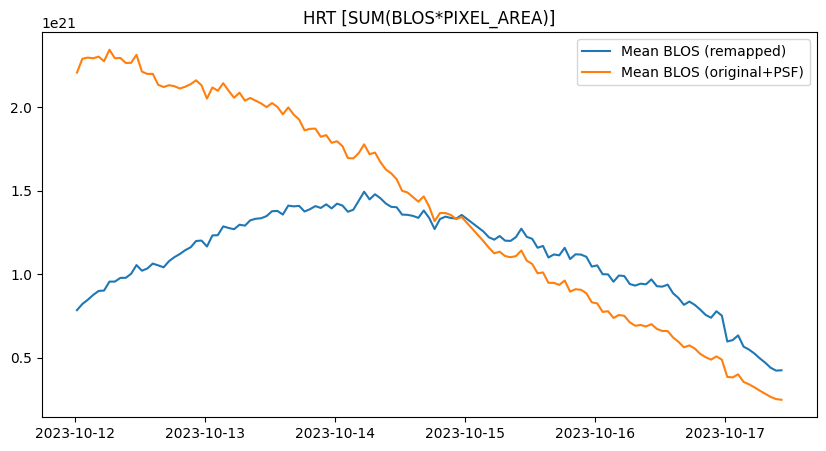

In [44]:
plt.figure(figsize=(10,5))
plt.plot(times, remap_blos_flux, label='Mean BLOS (remapped)')
plt.plot(times, flux_blos, label='Mean BLOS (original+PSF)')
plt.title('HRT [SUM(BLOS*PIXEL_AREA)]')
plt.legend()

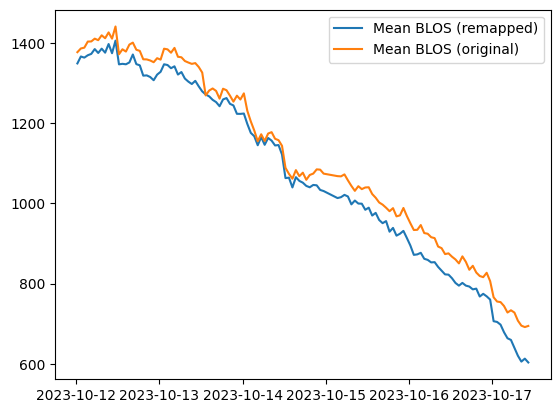

In [ ]:
plt.plot(times, remap_blos_mean, label='Mean BLOS (remapped)')
plt.plot(times, mean_blos, label='Mean BLOS (original+PSF)')
plt.legend()

# Compute HMI values (not all are fluxes....)

In [151]:
hmi_blos_pixels_list = []
hmi_mu_list = []

for i in range(128):
    tmp = hmi_ic_arr_nolimbdark[:,:,i] #720s are 4098,4098 arrays
    tmp_hmi = hmi_arr[2:-2,2:-2,i]
    tmp_hrt = hrt_arr[2:-2,2:-2,i]

    tmp[np.isnan(tmp_hrt)]=np.nan #mask out areas outside the HRT FOV
    hmi_umbra=np.where(tmp<=0.55)

    blos_pixels = tmp_hmi[hmi_umbra]
    hmi_blos_pixels_list.append(blos_pixels)
    hmi_mu_list.append(hmi_mu_arr[2:-2,2:-2,i][hmi_umbra])


In [164]:
remap_blos_flux_hmi = np.array([np.sum(blos_pixels)*hmisize**2 for blos_pixels in hmi_blos_pixels_list])
remap_blos_flux_hmi_mu_corr = np.array([np.sum(blos_pixels/hmi_mu_list[i])*hmisize**2 for i,blos_pixels in enumerate(hmi_blos_pixels_list)])
remap_blos_flux_hmi_mu_corr2 = np.array([np.sum(blos_pixels/(hmi_mu_list[i])*(hmisize**2/hmi_mu_list[i])) for i,blos_pixels in enumerate(hmi_blos_pixels_list)])

# Check how different the remapped HRT blos values are to HMI, and after applying the mu correction

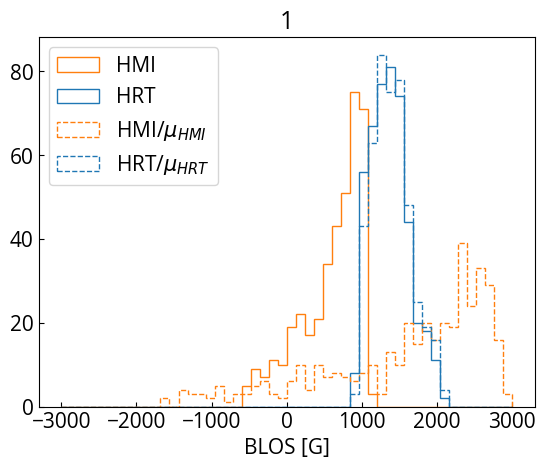

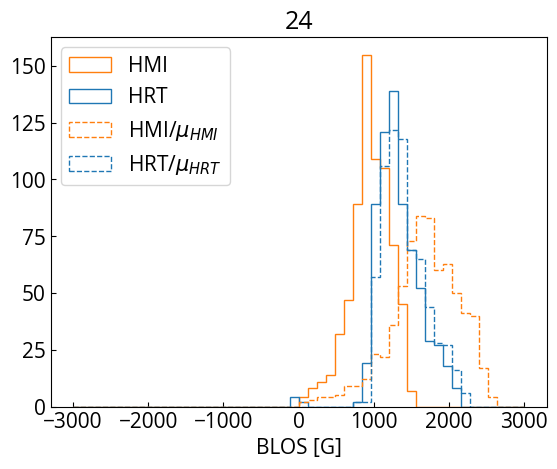

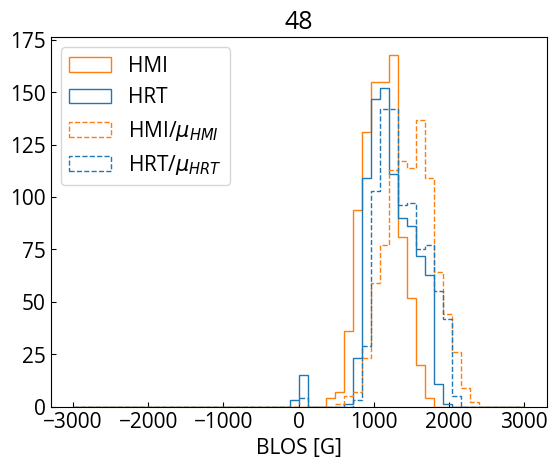

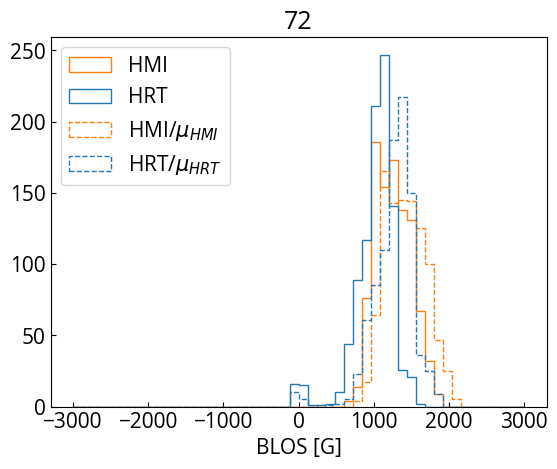

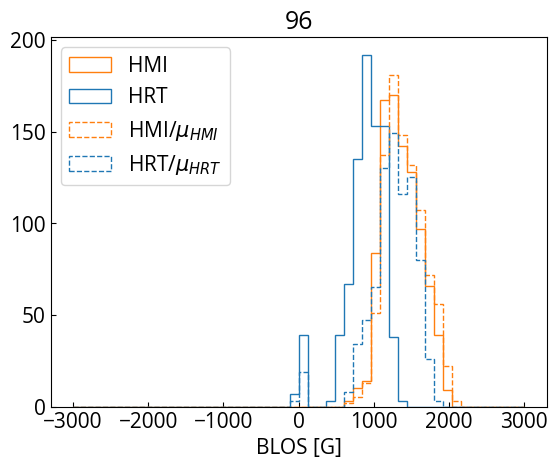

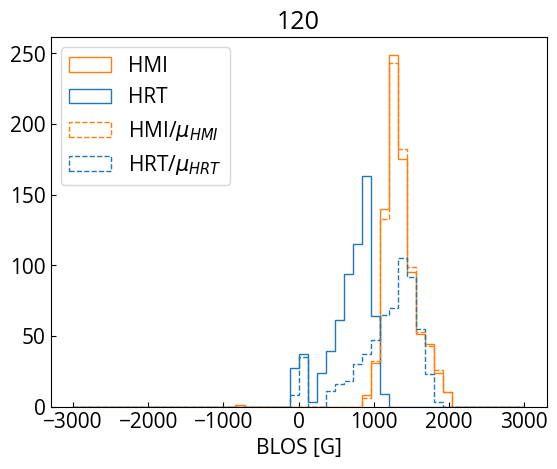

In [244]:
for i in [1,24,48,72,96,120]:

    plt.figure()
    plt.hist(hmi_blos_pixels_list[i].flatten(), bins=50, range=(-3000,3000),label='HMI', histtype='step',color='#ff7f0e')
    plt.hist(remap_blos_pix_list[i].flatten(), bins=50, range=(-3000,3000),label='HRT', histtype='step',color='#1f77b4')
    plt.hist(hmi_blos_pixels_list[i].flatten()/hmi_mu_list[i].flatten(), bins=50, range=(-3000,3000),label=r'HMI/$\mu_{HMI}$', histtype='step',color='#ff7f0e',linestyle='dashed')
    plt.hist(remap_blos_pix_list[i].flatten()/remap_hrt_mu_list[i].flatten(), bins=50, range=(-3000,3000),label=r'HRT/$\mu_{HRT}$', histtype='step',color='#1f77b4',linestyle='dashed')
    plt.xlabel('BLOS [G]')
    plt.title(str(i))
    plt.legend()
    plt.show()

# Area Comparison

In [250]:
area = [len(i)*hmisize**2 for i in hmi_blos_pixels_list]
hrt_area = [len(i)*pixel_size_ms[idx] for idx,i in enumerate(blos_pixels_list)]

In [251]:
area_mucorr = [np.sum(np.ones(len(i))*hmisize**2/hmi_mu_list[idx]) for idx,i in enumerate(hmi_blos_pixels_list)]
hrt_area_mucorr = [np.sum(np.ones(len(i))*pixel_size_ms[idx]/hrt_mu_list[idx]) for idx,i in enumerate(blos_pixels_list)]

In [252]:
hrt_umbra_avg_mu = np.array([0.97594054, 0.97521702, 0.97436354, 0.97350353, 0.97260135,
       0.97158362, 0.9706897 , 0.96967336, 0.96857037, 0.96751937,
       0.96634238, 0.96526607, 0.96409708, 0.96288255, 0.96156718,
       0.96028149, 0.9590465 , 0.95759522, 0.9560803 , 0.95455298,
       0.95312825, 0.95157122, 0.95016217, 0.94864909, 0.94695612,
       0.9452528 , 0.94368383, 0.94192563, 0.94021019, 0.93849229,
       0.93662481, 0.93470233, 0.93269888, 0.93070748, 0.92886301,
       0.92669771, 0.92454978, 0.92246249, 0.92028583, 0.91809095,
       0.91589416, 0.91382494, 0.9116764 , 0.90954431, 0.90720399,
       0.90496729, 0.90263048, 0.90006387, 0.89776652, 0.89520776,
       0.89262376, 0.89022219, 0.88762159, 0.88497874, 0.8824117 ,
       0.87946433, 0.87680262, 0.87410239, 0.87121037, 0.86832391,
       0.86533984, 0.8623344 , 0.85950775, 0.85632208, 0.85332934,
       0.85014615, 0.84701065, 0.84384244, 0.84082928, 0.83735055,
       0.83389489, 0.83055123, 0.81705005, 0.81318326, 0.80970773,
       0.80612891, 0.80242108, 0.79876517, 0.7948828 , 0.79132808,
       0.78733974, 0.78381163, 0.77988639, 0.77632928, 0.77251161,
       0.76827705, 0.76449391, 0.7596799 , 0.75563389, 0.75137917,
       0.7477379 , 0.74389478, 0.73917831, 0.73444944, 0.73042538,
       0.72589213, 0.7215015 , 0.71716034, 0.7123917 , 0.70782961,
       0.7034185 , 0.69859405, 0.69386954, 0.68896387, 0.6846617 ,
       0.68015298, 0.67557066, 0.67058698, 0.66609097, 0.66111806,
       0.65586354, 0.65102898, 0.6464109 , 0.64150299, 0.63646032,
       0.63095157, 0.62594386, 0.62165074, 0.61632171, 0.61182548,
       0.60633793, 0.60076235, 0.59580791, 0.59022231, 0.58409288,
       0.57877625, 0.57395522, 0.56864257])

hmi_umbra_avg_mu = np.array([0.36312173, 0.37121393, 0.38031668, 0.38917808, 0.39786947,
       0.40661507, 0.41506264, 0.42371354, 0.43253145, 0.44091909,
       0.4495272 , 0.45787227, 0.46636787, 0.47487079, 0.48350885,
       0.4918934 , 0.50014815, 0.50862263, 0.51723638, 0.52589918,
       0.53392183, 0.54211054, 0.55010566, 0.5581913 , 0.56623187,
       0.57430296, 0.58160215, 0.58936909, 0.59695811, 0.60442605,
       0.61206685, 0.61984504, 0.62742389, 0.63485188, 0.64220688,
       0.64976864, 0.65704306, 0.66438664, 0.6715523 , 0.67847995,
       0.68569703, 0.69217885, 0.69881584, 0.70529612, 0.7120898 ,
       0.71879207, 0.72520279, 0.73177089, 0.73804454, 0.74463998,
       0.75105567, 0.75699393, 0.76299519, 0.76914453, 0.7748698 ,
       0.78103011, 0.78672245, 0.79247811, 0.7982317 , 0.80380394,
       0.8094571 , 0.81490215, 0.8202622 , 0.82565924, 0.83100932,
       0.8362708 , 0.84147889, 0.8466908 , 0.8514855 , 0.85678517,
       0.86175977, 0.86646112, 0.88462133, 0.88907373, 0.89322227,
       0.89737446, 0.90134027, 0.90545024, 0.90930409, 0.91311197,
       0.91685238, 0.92045834, 0.92401906, 0.92737321, 0.93075483,
       0.93432454, 0.93763372, 0.94102069, 0.94399925, 0.94705887,
       0.94971315, 0.95258591, 0.95538618, 0.95811814, 0.96064925,
       0.9630937 , 0.96548226, 0.96781803, 0.96993256, 0.97207494,
       0.97411354, 0.97604159, 0.97783923, 0.97961768, 0.98120921,
       0.98271532, 0.98411801, 0.98551067, 0.98674138, 0.98797834,
       0.98910323, 0.99011714, 0.99107377, 0.9918703 , 0.99255805,
       0.99323135, 0.99380626, 0.99423582, 0.99461778, 0.99484417,
       0.99509424, 0.99517815, 0.99523173, 0.99519959, 0.99500163,
       0.99471572, 0.99438125, 0.99396448])

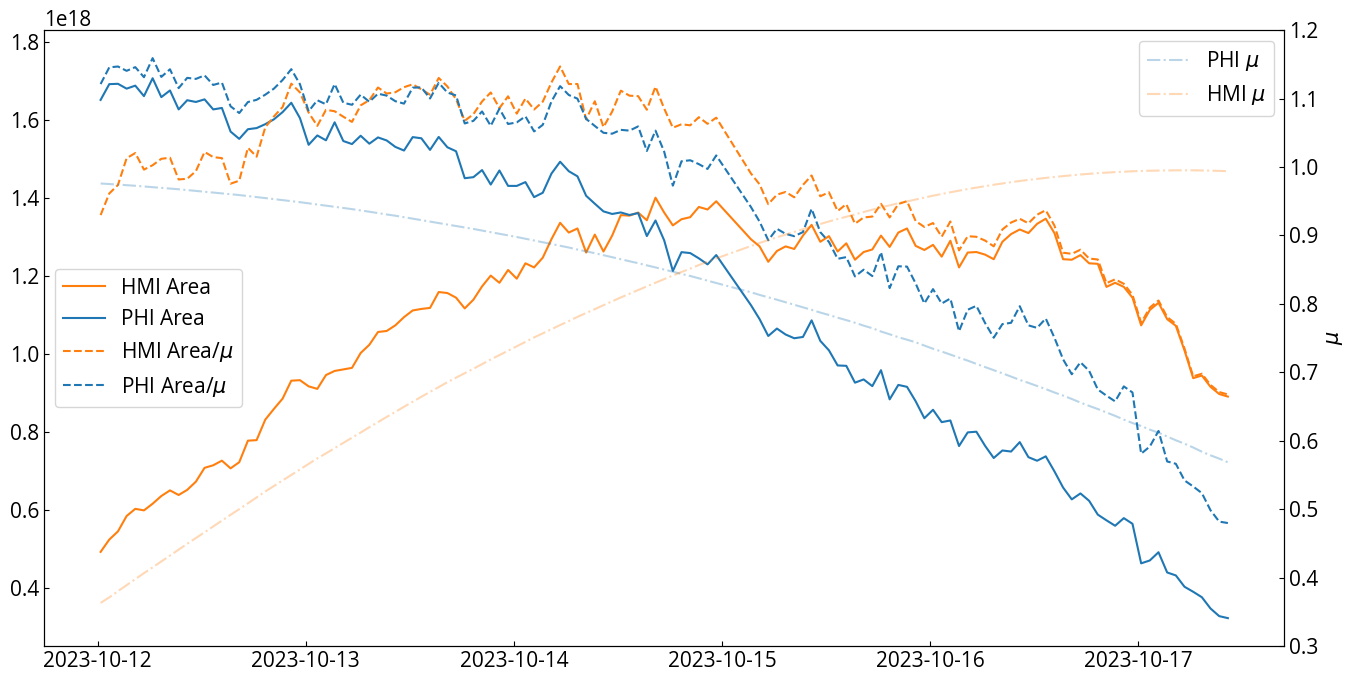

In [253]:
plt.figure(figsize=(16,8))
plt.plot(times,area, label='HMI Area',color='#ff7f0e')
plt.plot(times,hrt_area, label='PHI Area',color='#1f77b4')
#plt.plot(times,phi_remap_area, label='PHI Area (Remapped)',color='purple')
plt.plot(times,area_mucorr, label=r'HMI Area/$\mu$',color='#ff7f0e',linestyle='--')
plt.plot(times,hrt_area_mucorr, label=r'PHI Area/$\mu$',color='#1f77b4',linestyle='--')
plt.legend(loc='center left')

ax=plt.gca()
ax2=ax.twinx()

ax2.plot(times,hrt_umbra_avg_mu,label='PHI $\mu$', color='#1f77b4',alpha=0.3,linestyle='-.')
ax2.plot(times,hmi_umbra_avg_mu,label='HMI $\mu$', color='#ff7f0e',alpha=0.3,linestyle='-.')
ax2.legend(loc='center right')

ax2.set_ylabel(r'$\mu$')
ax2.set_ylim(0.3,1.2)



plt.legend()

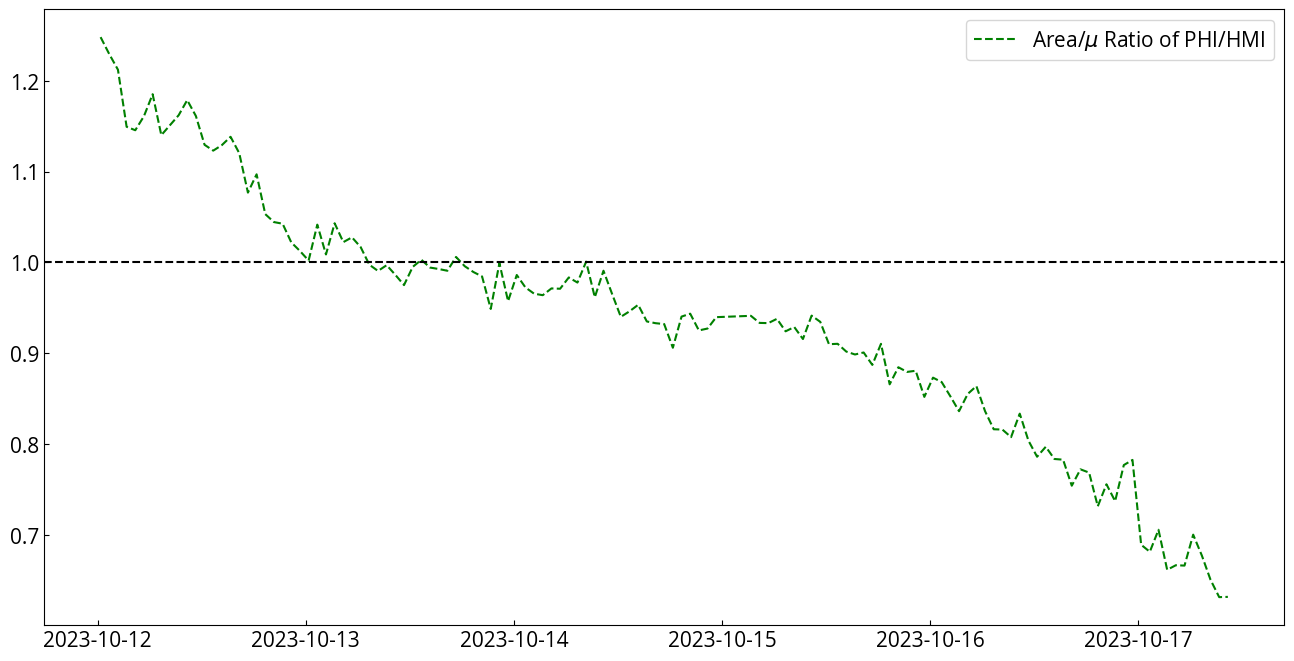

In [254]:
plt.figure(figsize=(16,8))

plt.plot(times,np.array(hrt_area_mucorr)/np.array(area_mucorr), label=r'Area/$\mu$ Ratio of PHI/HMI',color='green',linestyle='--')
plt.axhline(y=1, color='black', linestyle='--')
plt.legend()

# Try to make nice plots

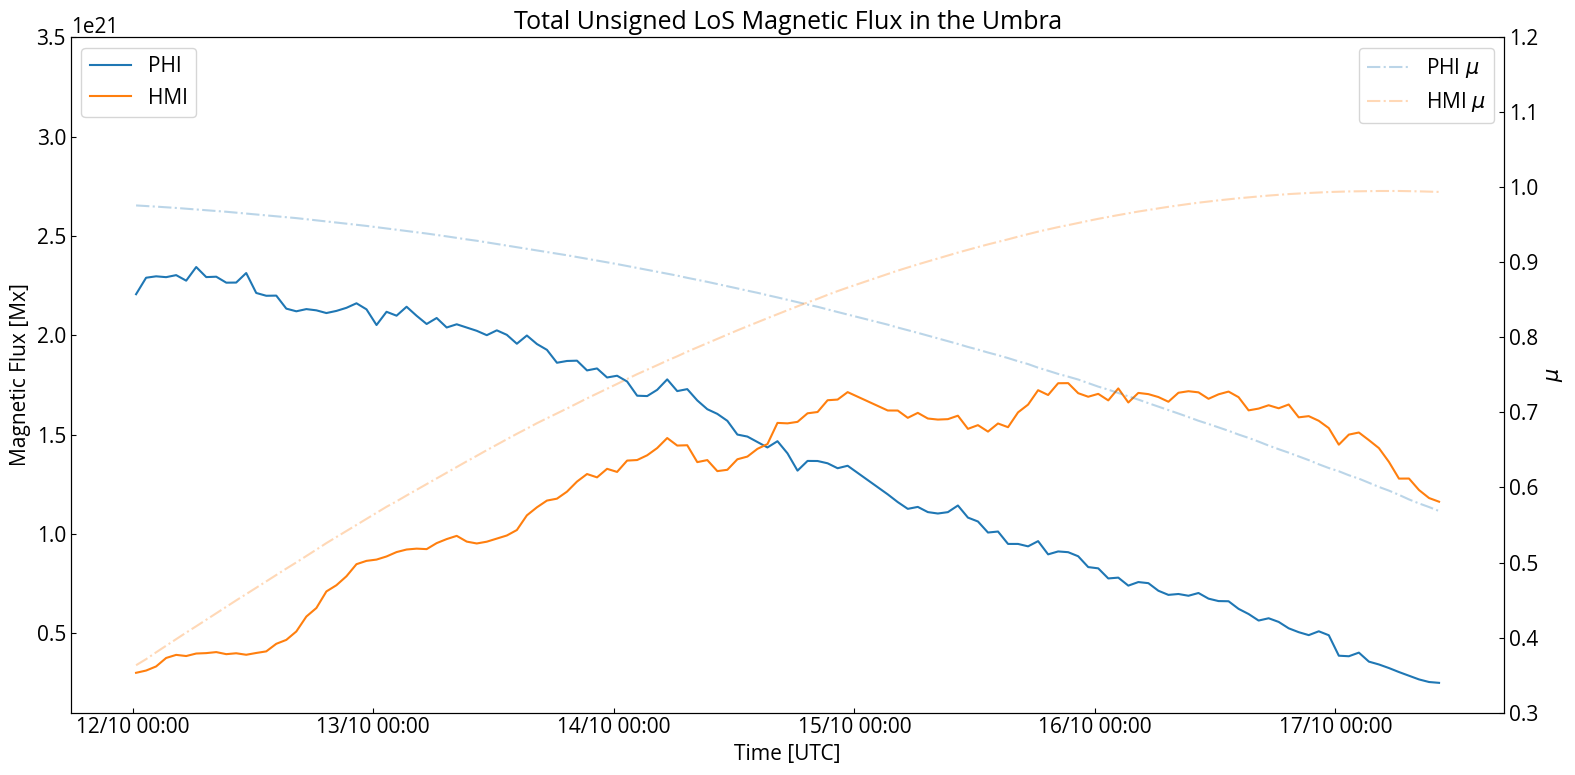

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(times, flux_blos, label='PHI',color='#1f77b4')
#plt.plot(times, remap_blos_flux, label='PHI (remapped)',color='purple')
#plt.plot(times, flux_blos_mu_corr, label=r'PHI/$\mu$',color='#1f77b4', linestyle='--')
plt.plot(times, remap_blos_flux_hmi, label='HMI',color='#ff7f0e')
#plt.plot(times, remap_blos_flux_hmi_mu_corr, label=r'HMI/$\mu$', linestyle='--',color='#ff7f0e')
plt.legend()
plt.ylim(1e20,3.5e21)
plt.xlabel('Time [UTC]')

plt.ylabel('Magnetic Flux [Mx]')
plt.legend(loc='upper left')

ax=plt.gca()
ax2=ax.twinx()

ax2.plot(times,hrt_umbra_avg_mu,label='PHI $\mu$', color='#1f77b4',alpha=0.3,linestyle='-.')
ax2.plot(times,hmi_umbra_avg_mu,label='HMI $\mu$', color='#ff7f0e',alpha=0.3,linestyle='-.')
plt.ylim(0.3,1.2)
plt.legend(loc='upper right')
plt.title(f'Total Unsigned LoS Magnetic Flux in the Umbra') 
plt.ylabel(r'$\mu$')

ax=plt.gca()
ax.xaxis.set_major_formatter(myFmt)
plt.tight_layout()
#plt.savefig('../plots/los_flux_umbra_no_mu_corr.png', bbox_inches='tight',dpi=300)

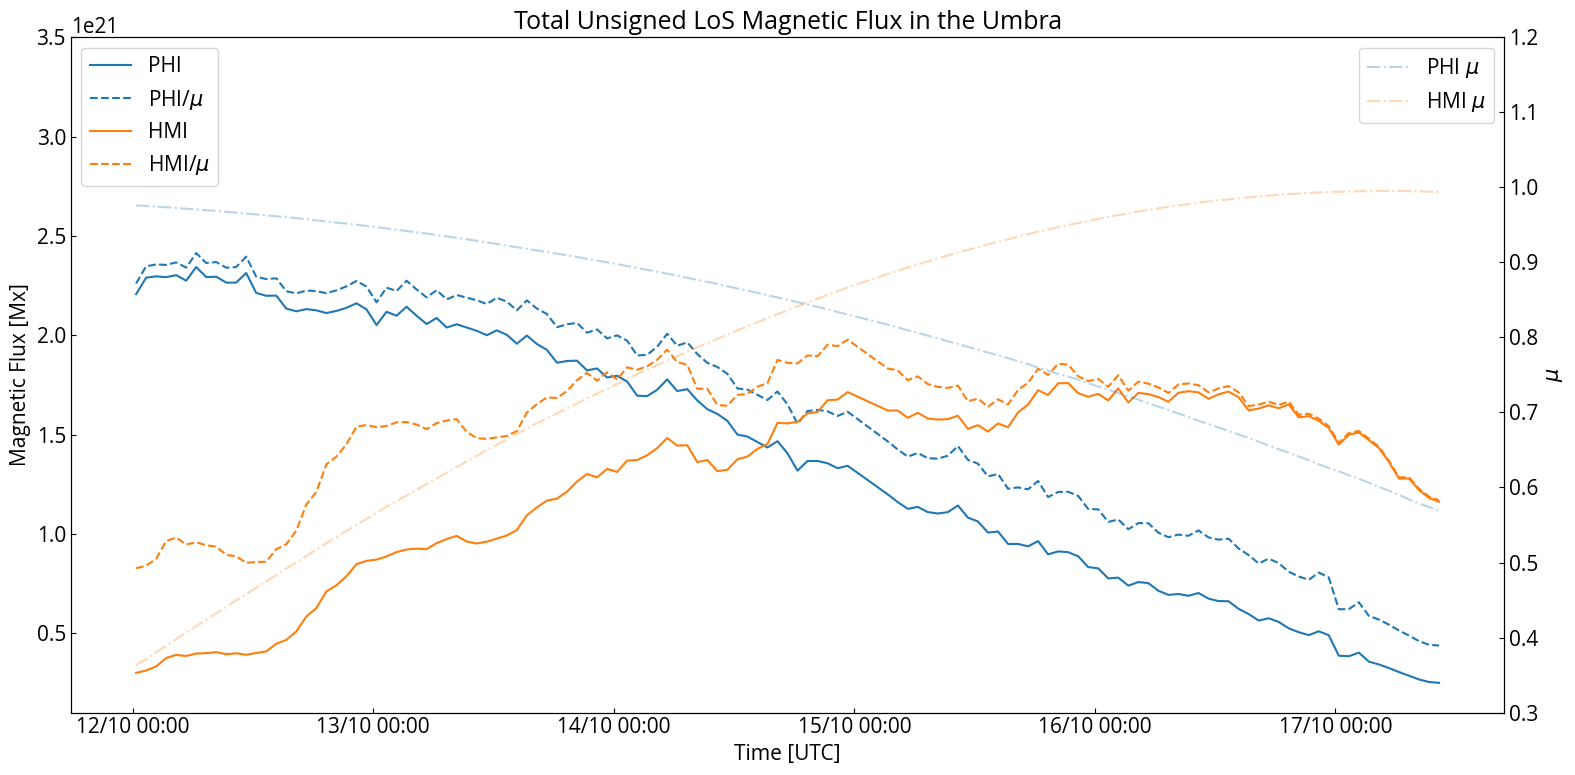

In [ ]:
#plt.plot(times, remap_blos_flux, label='Flux BLOS (remapped)')
plt.figure(figsize=(16,8))
plt.plot(times, flux_blos, label='PHI',color='#1f77b4')
plt.plot(times, flux_blos_mu_corr, label=r'PHI/$\mu$',color='#1f77b4', linestyle='--')
plt.plot(times, remap_blos_flux_hmi, label='HMI',color='#ff7f0e')
plt.plot(times, remap_blos_flux_hmi_mu_corr, label=r'HMI/$\mu$', linestyle='--',color='#ff7f0e')
plt.legend()
plt.ylim(1e20,3.5e21)
plt.xlabel('Time [UTC]')

plt.ylabel('Magnetic Flux [Mx]')
plt.legend(loc='upper left')

ax=plt.gca()
ax2=ax.twinx()

ax2.plot(times,hrt_umbra_avg_mu,label='PHI $\mu$', color='#1f77b4',alpha=0.3,linestyle='-.')
ax2.plot(times,hmi_umbra_avg_mu,label='HMI $\mu$', color='#ff7f0e',alpha=0.3,linestyle='-.')
plt.ylim(0.3,1.2)
plt.legend(loc='upper right')
plt.title(f'Total Unsigned LoS Magnetic Flux in the Umbra') 
plt.ylabel(r'$\mu$')

ax=plt.gca()
ax.xaxis.set_major_formatter(myFmt)
plt.tight_layout()
#plt.savefig('../plots/los_flux_umbra.png', bbox_inches='tight',dpi=300)

In [76]:
hmi_vr = [round(i['obs_vr']/1000,3) for i in hrt_meta_list]

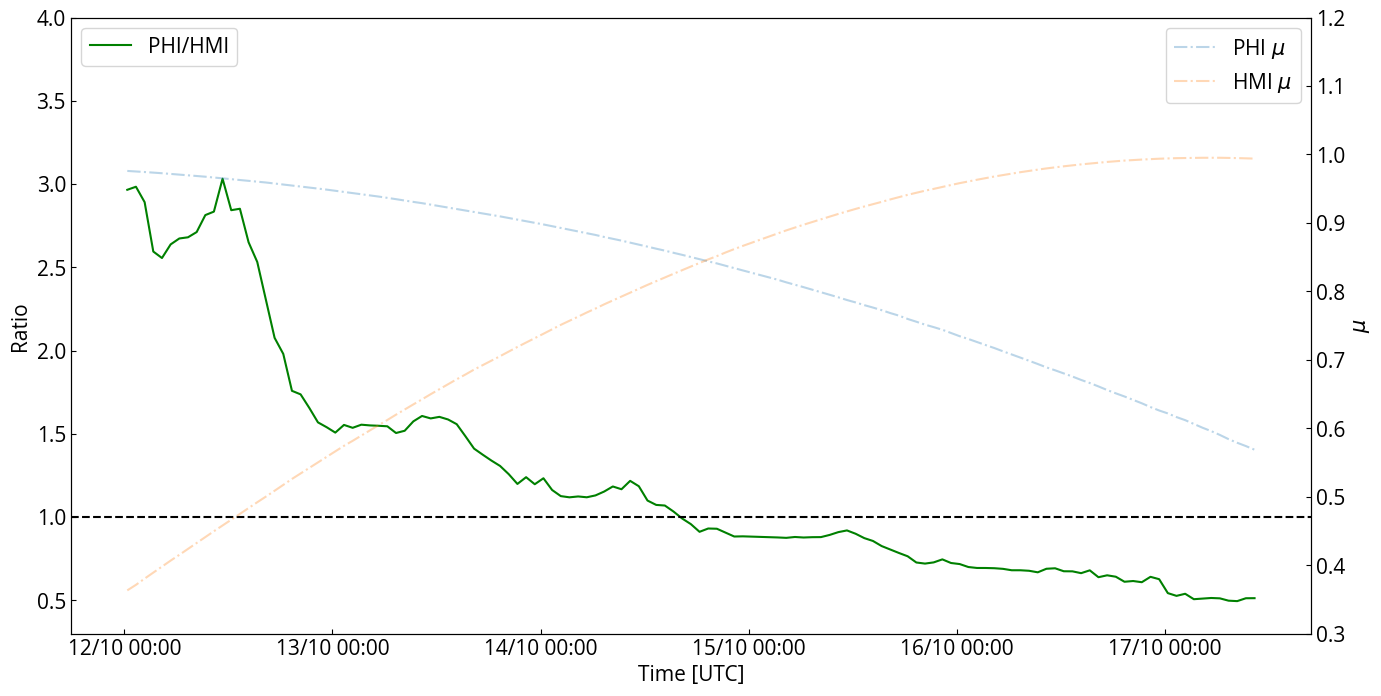

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(times,flux_blos_mu_corr/remap_blos_flux_hmi_mu_corr,label='PHI/HMI',color='green')
plt.axhline(y=1, color='black', linestyle='--')
#plt.plot(times,tmp_ichrtmu_nolimbdark_icnt_calib/tmp_ichmimu_nolimbdark,label='PHI/HMI calibrated',color='grey',linestyle='--')
# plt.plot(times,tmp_ichrtmu_nolimbdark_icnt/tmp_ichmimu_vec_nolimbdark/0.83,label='PHI/HMI Vec',color='purple')
plt.ylabel('Ratio')
plt.xlabel('Time [UTC]')
plt.legend(loc='upper left')
#plt.title(r'Ratio of $\mu$-corrected unsigned LoS flux')
plt.ylim(0.3,4)

ax=plt.gca()
ax2=ax.twinx()

ax2.plot(times,hrt_umbra_avg_mu,label='PHI $\mu$', color='#1f77b4',alpha=0.3,linestyle='-.')
ax2.plot(times,hmi_umbra_avg_mu,label='HMI $\mu$', color='#ff7f0e',alpha=0.3,linestyle='-.')
ax2.legend(loc='upper right')

ax2.set_ylabel(r'$\mu$')
ax2.set_ylim(0.3,1.2)
ax.xaxis.set_major_formatter(myFmt)

plt.savefig('../plots/los_flux_umbra_ratio_mu_corr.png', bbox_inches='tight',dpi=300)


In [52]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

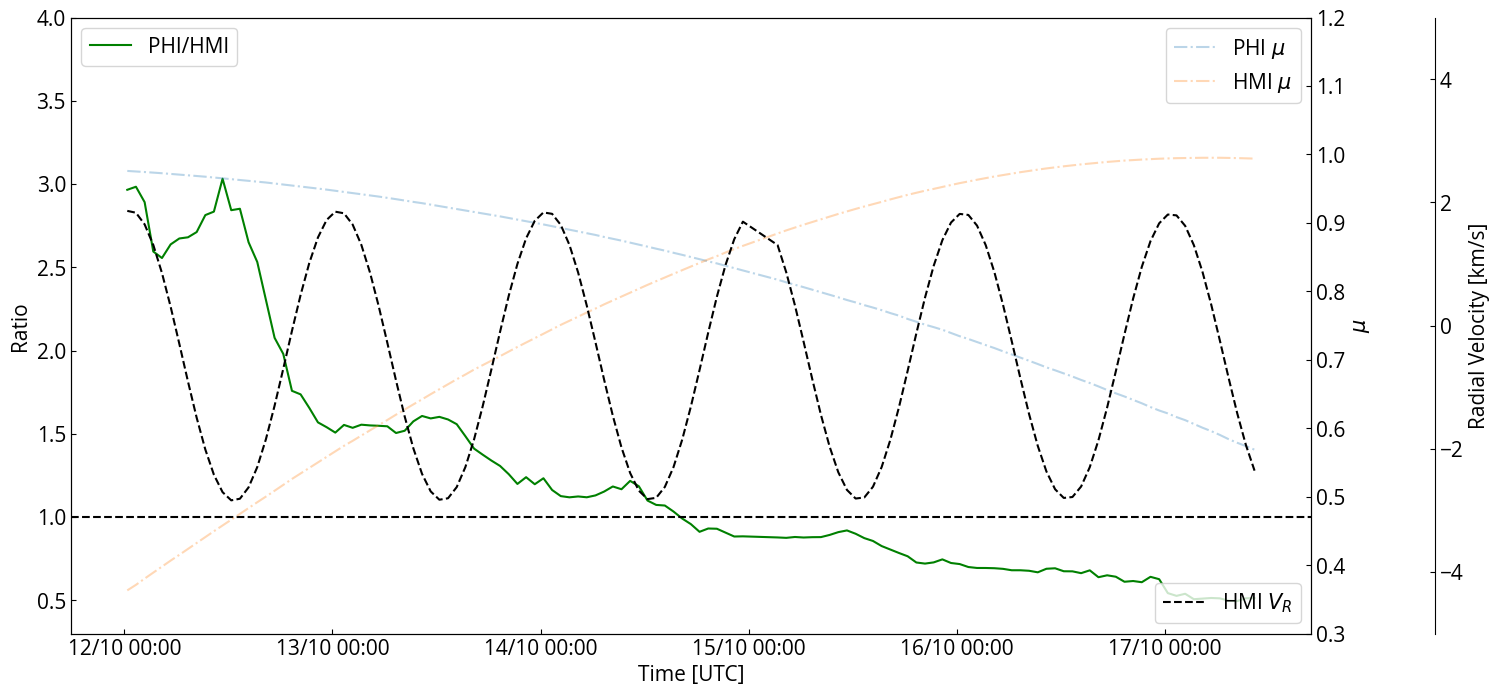

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(times,flux_blos_mu_corr/remap_blos_flux_hmi_mu_corr,label='PHI/HMI',color='green')
plt.axhline(y=1, color='black', linestyle='--')
plt.ylabel('Ratio')
plt.xlabel('Time [UTC]')
plt.legend(loc='upper left')

plt.ylim(0.3,4)

ax=plt.gca()
ax2=ax.twinx()
ax3=ax.twinx()

ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax2.plot(times,hrt_umbra_avg_mu,label='PHI $\mu$', color='#1f77b4',alpha=0.3,linestyle='-.')
ax2.plot(times,hmi_umbra_avg_mu,label='HMI $\mu$', color='#ff7f0e',alpha=0.3,linestyle='-.')
ax2.legend(loc='upper right')

ax2.set_ylabel(r'$\mu$')
ax2.set_ylim(0.3,1.2)
ax.xaxis.set_major_formatter(myFmt)

ax3.plot(times,hmi_vr,label=r'HMI $V_{R}$',alpha=1.0,color='black',linestyle='--')
ax3.set_ylabel(r'Radial Velocity [km/s]')
ax3.set_ylim(-5,5)
ax3.legend(loc='lower right')
ax2.set_ylabel(r'$\mu$')
ax2.set_ylim(0.3,1.2)
ax.xaxis.set_major_formatter(myFmt)

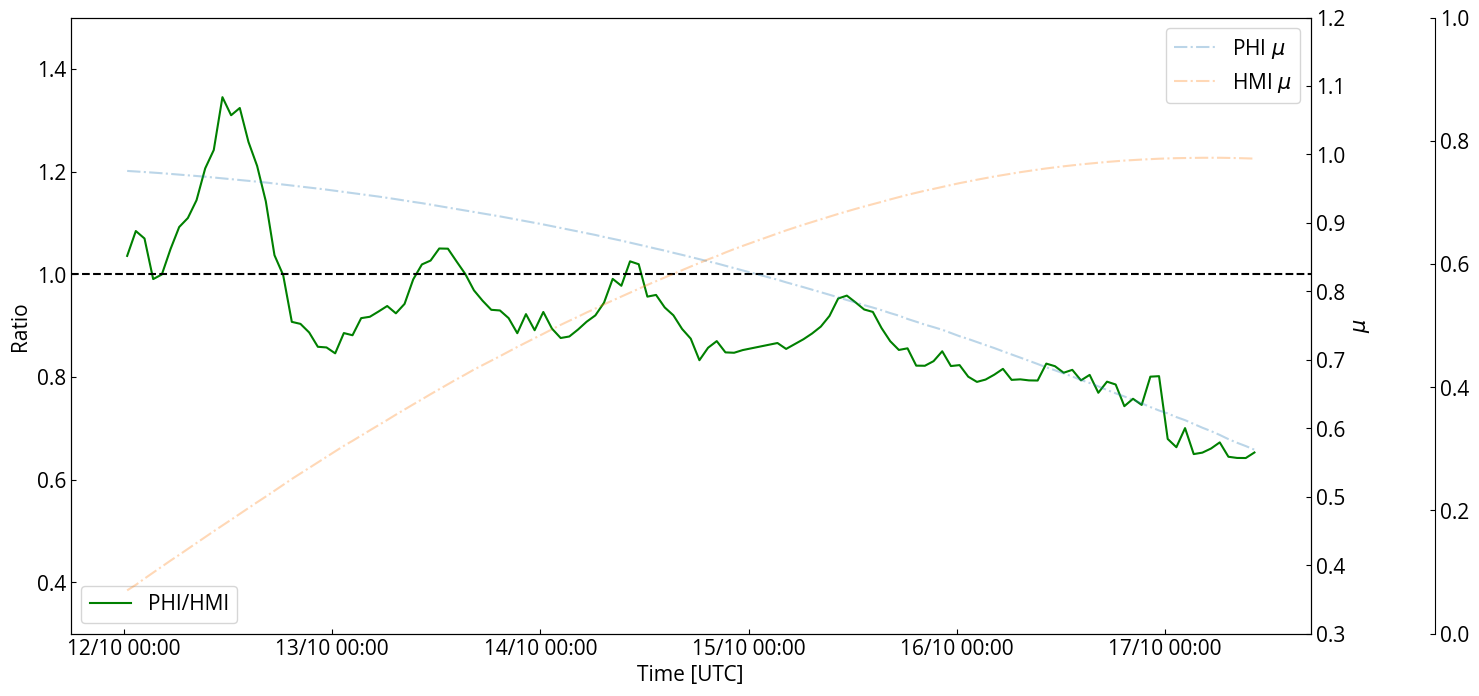

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(times,flux_blos_mu_corr2/remap_blos_flux_hmi_mu_corr2,label='PHI/HMI',color='green')
#plt.plot(times,remap_blos_flux_mu_corr/remap_blos_flux_hmi_mu_corr,label='PHI (remapped)/HMI',color='purple')
plt.axhline(y=1, color='black', linestyle='--')
plt.ylabel('Ratio')
plt.xlabel('Time [UTC]')
plt.legend(loc='lower left')

plt.ylim(0.3,1.5)

ax=plt.gca()
ax2=ax.twinx()
ax3=ax.twinx()

ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax2.plot(times,hrt_umbra_avg_mu,label='PHI $\mu$', color='#1f77b4',alpha=0.3,linestyle='-.')
ax2.plot(times,hmi_umbra_avg_mu,label='HMI $\mu$', color='#ff7f0e',alpha=0.3,linestyle='-.')
ax2.legend(loc='upper right')

ax2.set_ylabel(r'$\mu$')
ax2.set_ylim(0.3,1.2)
ax.xaxis.set_major_formatter(myFmt)

# ax3.plot(times,hmi_vr,label=r'HMI $V_{R}$',alpha=1.0,color='black',linestyle='--')
# ax3.set_ylabel(r'Radial Velocity [km/s]')
# ax3.set_ylim(-5,5)
# ax3.legend(loc='lower right')
# ax2.set_ylabel(r'$\mu$')
# ax2.set_ylim(0.3,1.2)
ax.xaxis.set_major_formatter(myFmt)

# Kill 12 + 24h signal (+ harmonics?)

In [63]:
new_times = [dt(2023,10,15,0,19,59),dt(2023,10,15,1,19,59),dt(2023,10,15,2,19,59)]

In [66]:
full_times = times.copy()
full_times[72:72] = new_times

In [166]:
signal = flux_blos_mu_corr2/remap_blos_flux_hmi_mu_corr2

In [167]:
new_signals = [signal[71],signal[71],signal[71]]

full_signals = list(signal).copy()
full_signals[72:72] = new_signals

/tmp/ipykernel_6119/2189353566.py:14: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_freqs


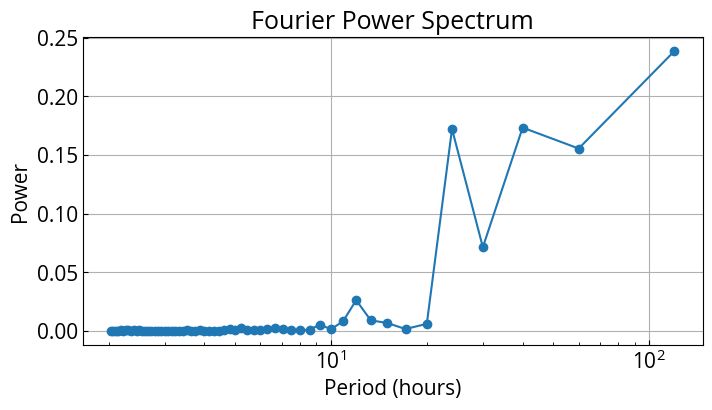

In [233]:
fft_values = np.fft.fft(full_signals[:120])
n_hours = len(full_signals[:120])
power_spectrum = np.abs(fft_values) ** 2 / n_hours  # Normalize by number of points

# Compute frequencies (in cycles per hour)
n = len(full_signals[:120])
freqs = np.fft.fftfreq(n, d=1)  # d=1 since data is hourly

# Only take the positive half of the spectrum
positive_freqs = freqs[:n // 2]
positive_power = power_spectrum[:n // 2]

# Convert to hours (period = 1 / frequency)
periods = 1 / positive_freqs
valid_indices = np.isfinite(periods) & (periods > 0)  # Remove infinities and negatives

# Plot
plt.figure(figsize=(8, 4))
plt.plot(periods[valid_indices], positive_power[valid_indices], marker='o', linestyle='-')
plt.xlabel("Period (hours)")
plt.ylabel("Power")
plt.title("Fourier Power Spectrum")
plt.xscale("log")  # Log scale to better see long periods
plt.grid()
plt.show()

In [227]:
1/freqs

/tmp/ipykernel_6119/2616668683.py:1: RuntimeWarning: divide by zero encountered in divide
  1/freqs


array([          inf,  120.        ,   60.        ,   40.        ,
         30.        ,   24.        ,   20.        ,   17.14285714,
         15.        ,   13.33333333,   12.        ,   10.90909091,
         10.        ,    9.23076923,    8.57142857,    8.        ,
          7.5       ,    7.05882353,    6.66666667,    6.31578947,
          6.        ,    5.71428571,    5.45454545,    5.2173913 ,
          5.        ,    4.8       ,    4.61538462,    4.44444444,
          4.28571429,    4.13793103,    4.        ,    3.87096774,
          3.75      ,    3.63636364,    3.52941176,    3.42857143,
          3.33333333,    3.24324324,    3.15789474,    3.07692308,
          3.        ,    2.92682927,    2.85714286,    2.79069767,
          2.72727273,    2.66666667,    2.60869565,    2.55319149,
          2.5       ,    2.44897959,    2.4       ,    2.35294118,
          2.30769231,    2.26415094,    2.22222222,    2.18181818,
          2.14285714,    2.10526316,    2.06896552,    2.03389

10
0.08333333333333333
12
5
0.041666666666666664
12


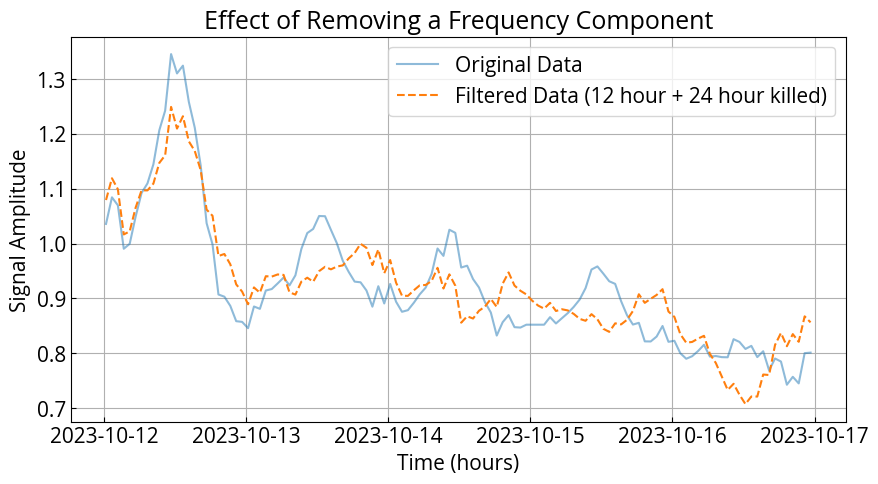

In [234]:
target_period = 12

new_fft_values = fft_values.copy()

num_harmonics = 2  # Number of harmonics to remove
for i in range(1, num_harmonics + 1):  # 1st harmonic, 2nd harmonic, etc.
    harmonic_freq = 1/ (i * target_period)
    abs_diff = np.abs(freqs - harmonic_freq)

    target_idx = np.argmin(abs_diff)

    print(target_idx)
    print(harmonic_freq)
    print(target_period)
    
    # Set both positive and negative frequency components to zero
    new_fft_values[target_idx] = 0
    new_fft_values[-target_idx] = 0  
    
    # if i*target_period == 24:
    #     sorted_indices = np.argsort(abs_diff)
    #     target_2nd_idx = sorted_indices[1]

    #     print(target_2nd_idx)
    #     print(1/freqs[target_2nd_idx])

    #     new_fft_values[target_2nd_idx] = 0
    #     new_fft_values[-target_2nd_idx] = 0 


# Reconstruct the signal using inverse FFT
filtered_data = np.fft.ifft(new_fft_values).real  # Take only the real part

# Plot the original and filtered signals
plt.figure(figsize=(10, 5))
plt.plot(full_times[:120], full_signals[:120], label="Original Data", alpha=0.5)
plt.plot(full_times[:120], filtered_data, label="Filtered Data (12 hour + 24 hour killed)", linestyle="--")
plt.xlabel("Time (hours)")
plt.ylabel("Signal Amplitude")
plt.title("Effect of Removing a Frequency Component")
plt.legend()
plt.grid()
plt.show()

In [232]:
1/freqs

/tmp/ipykernel_6119/2616668683.py:1: RuntimeWarning: divide by zero encountered in divide
  1/freqs


array([          inf,  120.        ,   60.        ,   40.        ,
         30.        ,   24.        ,   20.        ,   17.14285714,
         15.        ,   13.33333333,   12.        ,   10.90909091,
         10.        ,    9.23076923,    8.57142857,    8.        ,
          7.5       ,    7.05882353,    6.66666667,    6.31578947,
          6.        ,    5.71428571,    5.45454545,    5.2173913 ,
          5.        ,    4.8       ,    4.61538462,    4.44444444,
          4.28571429,    4.13793103,    4.        ,    3.87096774,
          3.75      ,    3.63636364,    3.52941176,    3.42857143,
          3.33333333,    3.24324324,    3.15789474,    3.07692308,
          3.        ,    2.92682927,    2.85714286,    2.79069767,
          2.72727273,    2.66666667,    2.60869565,    2.55319149,
          2.5       ,    2.44897959,    2.4       ,    2.35294118,
          2.30769231,    2.26415094,    2.22222222,    2.18181818,
          2.14285714,    2.10526316,    2.06896552,    2.03389

/tmp/ipykernel_6119/3464053808.py:14: RuntimeWarning: divide by zero encountered in divide
  nperiods = 1/ npositive_freqs


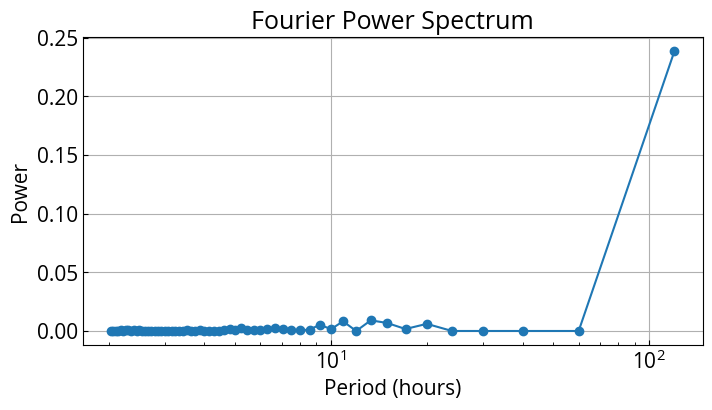

In [231]:
nfft_values = np.fft.fft(filtered_data)
n_hours = len(full_signals[:120])
npower_spectrum = np.abs(nfft_values) ** 2 / n_hours  # Normalize by number of points

# Compute frequencies (in cycles per hour)
n = len(full_signals[:120])
nfreqs = np.fft.fftfreq(n, d=1)  # d=1 since data is hourly

# Only take the positive half of the spectrum
npositive_freqs = nfreqs[:n // 2]
npositive_power = npower_spectrum[:n // 2]

# Convert to hours (period = 1 / frequency)
nperiods = 1/ npositive_freqs
valid_indices = np.isfinite(nperiods) & (nperiods > 0)  # Remove infinities and negatives

# Plot
plt.figure(figsize=(8, 4))
plt.plot(nperiods[valid_indices], npositive_power[valid_indices], marker='o', linestyle='-')
plt.xlabel("Period (hours)")
plt.ylabel("Power")
plt.title("Fourier Power Spectrum")
plt.xscale("log")  # Log scale to better see long periods
plt.grid()
plt.show()

# CLV explore

In [172]:
def muSO_map(h,shape):
    if type(h) is str:
        h = fits.getheader(h)
    center=center_coord(h)
    try:
        Rpix=(h['RSUN_ARC']/h['CDELT1']) # PHI
    except:
        Rpix=(h['RSUN_OBS']/h['CDELT1']) # HMI
    
    X,Y = np.meshgrid(np.arange(shape[1]) - center[0],np.arange(shape[0]) - center[1])
    mu = np.sqrt(Rpix**2 - (X**2 + Y**2)) / Rpix
    return mu

def CLV(mu):
    # input from muSO_map
    p = np.asarray([0.32519, 1.26432, -1.44591, 1.55723, -0.87415, 0.17333]) # from Pierce & Slughter 1977
    clv = np.zeros(mu.shape)
    for i in range(6):
        clv += p[i] * mu**i
        
    return clv

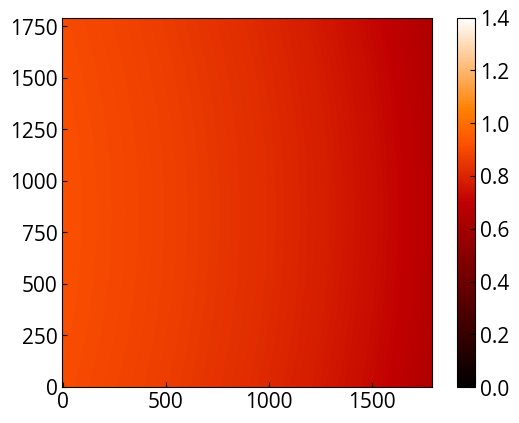

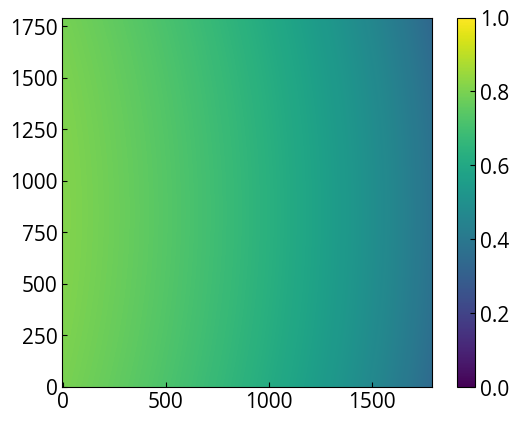

In [179]:
for icnt, blos in zip(hrt_icfiles[-1:],hrt_files[-1:]):
    icnt_data = fits.getdata(icnt)
    blos_data = fits.getdata(blos)

    h = fits.getheader(icnt)

    #get the mu values for the blos pixels
    fileDID = h['PHIDATID']
    date = icnt.split('202310')[1].split('T')[0]

    wcs_corr_file = f'/data/slam/sinjan/arlongterm_hrt_wcs_corr/hrt_CRVAL_corrections_202310{date}.json'

    with open(wcs_corr_file) as f:
        err = json.load(f)

    err1 = err[fileDID]
    errx = err1[0]
    erry = err1[1]
    h['CRVAL1']=h['CRVAL1']-errx
    h['CRVAL2']=h['CRVAL2']-erry
    
    mu = muSO_map(h,blos_data.shape)
    clv = CLV(mu)

    plt.figure()
    plt.imshow(clv,origin="lower", vmin=0, vmax=1.4, cmap='gist_heat')
    plt.colorbar()
    plt.show()

    plt.figure()
    plt.imshow(mu,origin="lower", vmin=0, vmax=1, cmap='viridis')
    plt.colorbar()
    plt.show()


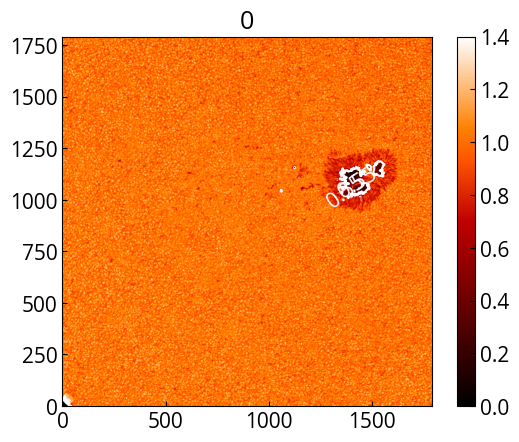

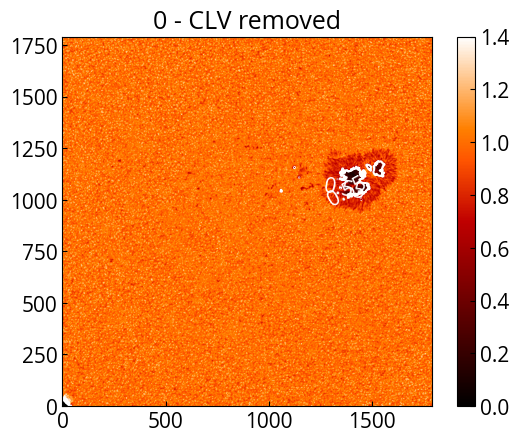

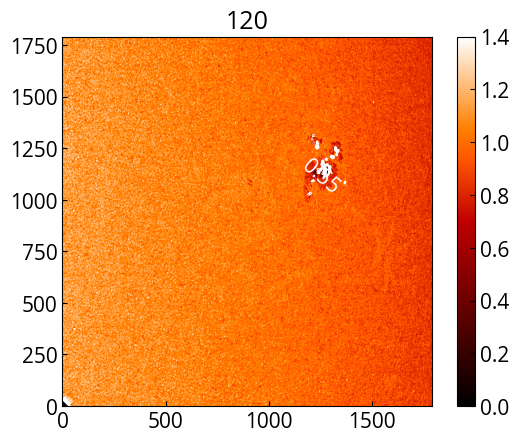

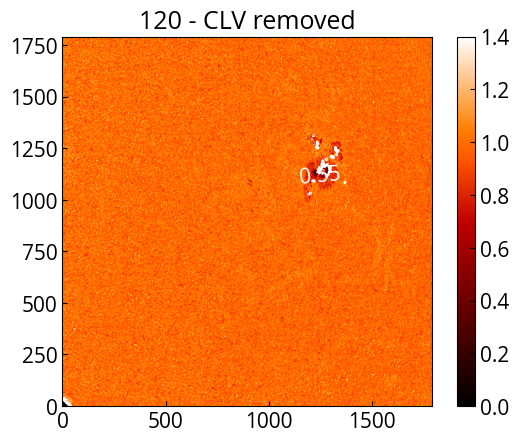

In [221]:
for file_ID in [0,120]:

    icnt_test = fits.getdata(hrt_icfiles[file_ID])

    h = fits.getheader(hrt_icfiles[file_ID])

    #get the mu values for the blos pixels
    fileDID = h['PHIDATID']
    date = hrt_icfiles[file_ID].split('202310')[1].split('T')[0]

    wcs_corr_file = f'/data/slam/sinjan/arlongterm_hrt_wcs_corr/hrt_CRPIX_corrections_202310{date}.json'

    with open(wcs_corr_file) as f:
        err = json.load(f)

    err1 = err[fileDID]
    errx = err1[0]
    erry = err1[1]
    h['CRPIX1']=h['CRPIX1']-errx
    h['CRPIX2']=h['CRPIX2']-erry

    mu = muSO_map(h,blos_data.shape)
    clv = CLV(mu)

    new = icnt_test/clv

    norm_pix = np.where((mu >= 0.8) & (icnt_data >= 0.8))

    new_norm = new[norm_pix].mean()

    new /= new_norm

    plt.figure()
    plt.title(f'{file_ID}')
    im=plt.imshow(icnt_test,origin="lower", vmin=0, vmax=1.4, cmap='gist_heat')
    CS=plt.contour(icnt_test, levels=[0.55], colors='white')
    plt.clabel(CS)
    plt.colorbar(im)

    plt.figure()
    plt.title(f'{file_ID} - CLV removed')
    im2=plt.imshow(new,origin="lower", vmin=0, vmax=1.4, cmap='gist_heat')
    CS=plt.contour(new, levels=[0.55], colors='white')
    plt.clabel(CS)
    plt.colorbar(im2)

    # plt.hist(icnt_test.flatten(), bins=100, label='og', histtype='step')
    # plt.hist(new.flatten(), bins=100, label='new', histtype='step')
    # plt.title(f'{file_ID}')
    # plt.yscale('log')
    # plt.legend()
    # plt.show()

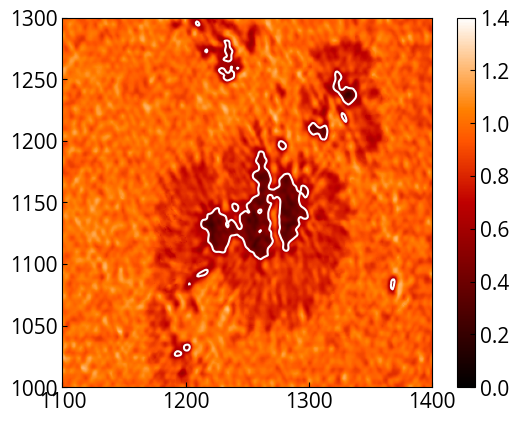

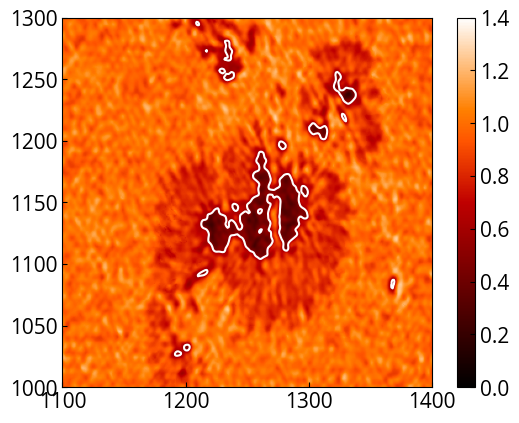

In [213]:
plt.figure()
im=plt.imshow(icnt_test,origin="lower", vmin=0, vmax=1.4, cmap='gist_heat')
CS=plt.contour(icnt_test, levels=[0.55], colors='white')
#plt.clabel(CS)
plt.xlim(1100,1400)
plt.ylim(1000,1300)
plt.colorbar(im)

plt.figure()
im2=plt.imshow(new,origin="lower", vmin=0, vmax=1.4, cmap='gist_heat')
CS=plt.contour(new, levels=[0.55], colors='white')
#plt.clabel(CS)
plt.xlim(1100,1400)
plt.ylim(1000,1300)
plt.colorbar(im2)

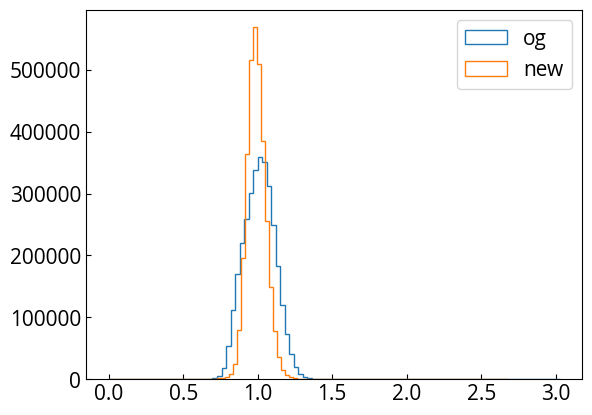

In [215]:
plt.hist(icnt_test.flatten(), bins=100, label='og', histtype='step')
plt.hist(new.flatten(), bins=100, label='new', histtype='step')
plt.legend()
plt.show()

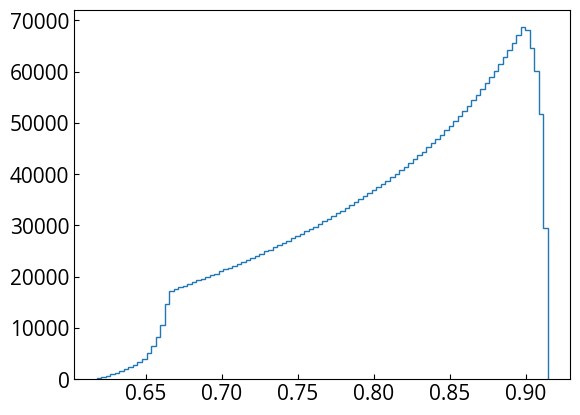

In [184]:
plt.figure()
plt.hist(clv.flatten(), bins=100, label='Histogram of CLV', histtype='step')
plt.show()